In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import os, sys, argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from glob import glob
from PIL import Image
from copy import copy

os.environ['CUDA_VISIBLE_DEVICES'] = '5'

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
sys.path.append('model_opts')
from feature_extraction import *
from feature_reduction import *
from model_options import *
from mapping_methods import *

from sklearn.linear_model import RidgeCV
from scipy.stats import pearsonr

from sklearn.metrics import explained_variance_score as ev_score
from sklearn.preprocessing import scale

def pearson_r_score(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

scoring_metrics = {'ev_score': ev_score, 
                   'pearson_r': pearson_r_score}

from processing import *

In [3]:
model_string = 'vit_base_patch16_224_imagenet'
model_options = get_model_options()
image_transforms = get_recommended_transforms(model_string)

model_name = model_options[model_string]['model_name']
train_type = model_options[model_string]['train_type']
model_call = model_options[model_string]['call']

In [4]:
model = eval(model_call)
model = model.eval()
if torch.cuda.is_available():
    model = model.cuda()

In [5]:
image_dfdict = {}
asset_dictlist = []
for imageset in ['oasis', 'vessel']:
    root = 'images/{}/'.format(imageset)
    assets = glob(root + '*.jpg')
    for asset in assets:
        imgstr = asset.split('/')[-1]
        row = {'image_name': imgstr,
               'dataset': imageset}
        asset_dictlist.append(row)
    image_df = (pd.DataFrame(asset_dictlist)
                .sort_values(by='image_name', ignore_index=True))

In [7]:
stimulus_loader = DataLoader(dataset=StimulusSet(image_df, image_transforms), batch_size=64)

In [9]:
stimulus_features = srp_extraction(model_string, model_inputs = stimulus_loader, delete_saved_outputs = False,
                                   output_dir = 'srp_arrays/{}'.format(imageset))

Computing 6246 SRPs for vit_base_patch16_224_imagenet on TITAN RTX...


SRP Extraction (Layer):   0%|          | 0/114 [00:00<?, ?it/s]

In [52]:
import skdim

#generate data : np.array (n_points x n_dim). Here a uniformly sampled 5-ball embedded in 10 dimensions
data = np.zeros((1000,10))
data[:,:5] = skdim.datasets.hyperBall(n = 1000, d = 5, radius = 1, random_state = 0)

#estimate global intrinsic dimension
danco = skdim.id.DANCo().fit(data)
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(data, n_neighbors = 100, n_jobs = 1)

#get estimated intrinsic dimension
print(danco.dimension_, np.mean(lpca.dimension_pw_))

5.263789923312668 5.0


In [85]:
intrinsic_dims = []
for model_layer_index, model_layer in enumerate(tqdm(stimulus_features)):
    idims = skdim.id.lPCA().fit(stimulus_features[model_layer]).dimension_
    intrinsic_dims.append({'model_layer': model_layer, 'model_layer_index': model_layer_index,
                           'intrinsic_dimensionality': idims, 'model': model_name})
    
intrinsic_dimensionality = pd.DataFrame(intrinsic_dims)

  0%|          | 0/114 [00:00<?, ?it/s]

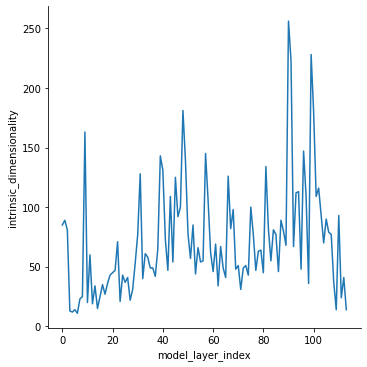

In [86]:
sns.relplot(data = intrinsic_dimensionality, x = 'model_layer_index', 
            y = 'intrinsic_dimensionality', kind = 'line');

In [10]:
x = np.round(stimulus_features['Linear-45'][(response_data['dataset'] == 'oasis') & 
                               (response_data['image_type'] == 'Scene')], 4)

In [11]:
x = stimulus_features['Linear-45'][(response_data['dataset'] == 'oasis') & 
                                   (response_data['image_type'] == 'Scene')]

In [114]:
#pd.DataFrame(x).to_csv('ed_sample.csv', index = None)

### Effective Dimensionality Method 1

In [15]:
#matrix = np.corrcoef(x)
matrix = np.cov(x.T)
eigen_val = np.array(sorted(np.linalg.eig(matrix)[0]))

In [16]:
K = len(eigen_val)
eigen_sum = sum(eigen_val)
norm_eigen_val = eigen_val/eigen_sum
eigen_var = np.var(eigen_val)*((K-1)/K)

In [17]:
n1 = np.prod(norm_eigen_val**(-norm_eigen_val))  
n2 = (eigen_sum**2)/sum(eigen_val**2) 
nInf = eigen_sum/max(eigen_val)    
nC = K - ((K**2)/(eigen_sum**2))*eigen_var

In [18]:
print(n1, n2, nInf, nC)

(170.74789148575206+3.414571456699466e-14j) (117.18742891559265+0j) (22.95113746328721+0j) (6193.709140905426+0j)


### Effective Dimensionality Method 2

In [19]:
pca = PCA().fit(x); eigen_val = np.array(sorted(pca.explained_variance_))

In [20]:
K = len(eigen_val)
eigen_sum = sum(eigen_val)
norm_eigen_val = eigen_val/eigen_sum
eigen_var = np.var(eigen_val)*((K-1)/K)

In [21]:
n1 = np.prod(norm_eigen_val**(-norm_eigen_val))  
n2 = (eigen_sum**2)/sum(eigen_val**2) 
nInf = eigen_sum/max(eigen_val)    
nC = K - ((K**2)/(eigen_sum**2))*eigen_var

In [22]:
print(n1, n2, nInf, nC)

170.74789148575158 117.18742891559295 22.951137463287274 219.1266534118642


In [32]:
def calculate_effective_dims(x):
    pca = PCA().fit(x)
    eigvals = np.array(sorted(pca.explained_variance_))
    
    K = len(eigvals)
    eigen_sum = sum(eigvals)
    norm_eigvals = eigvals/eigen_sum
    eigen_var = np.var(eigvals)*((K-1)/K)
    
    return np.prod(norm_eigvals**(-norm_eigvals))

In [33]:
calculate_effective_dims(x)

170.74789148575158

In [30]:
effective_dims = []
for model_layer_index, model_layer in enumerate(tqdm(stimulus_features)):
    edims = calculate_effective_dims(stimulus_features[model_layer])
    effective_dims.append({'model_layer': model_layer, 'model_layer_index': model_layer_index,
                           'effective_dimensionality': edims, 'model': model_name})
    
effective_dimensionality = pd.DataFrame(effective_dims)

  0%|          | 0/114 [00:00<?, ?it/s]

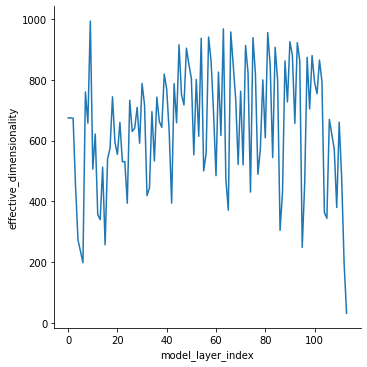

In [31]:
sns.relplot(data = effective_dimensionality, x = 'model_layer_index', 
            y = 'effective_dimensionality', kind = 'line');

In [ ]:
max_transform(effective_dimensionality, measure_var = 'effective_dimensionality', group_vars = []

,model_layer,model_layer_index,effective_dimensionality,model
0,GELU-1,9,993.564716,vit_base_patch16_224


In [288]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
X = datasets.load_iris()['data']
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_scaled)

print('Explained Variance = ', pca.explained_variance_)
print('Principal Components = ', pca.components_)

Explained Variance =  [2.93808505 0.9201649  0.14774182 0.02085386]
Principal Components =  [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]
 [-0.71956635  0.24438178  0.14212637  0.63427274]
 [-0.26128628  0.12350962  0.80144925 -0.52359713]]


In [289]:
cov = np.cov(X_scaled.T)
eig_val, eig_vec = np.linalg.eig(cov)
print('Eigenvalues = ', eig_val)
print('Eigenvectors = ', eig_vec)

Eigenvalues =  [2.93808505 0.9201649  0.14774182 0.02085386]
Eigenvectors =  [[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]


In [51]:
max_transform(cross_decoding_scores.groupby(['model','model_layer','model_layer_index'])['cross_score']
              .mean().reset_index(), group_vars = ['model'], measure_var = 'cross_score')

,model,model_layer,model_layer_index,cross_score
0,vit_base_patch16_224,Linear-45,103,0.390973


### Scratchpad

In [52]:
import skdim
import numpy as np

#generate data : np.array (n_points x n_dim). Here a uniformly sampled 5-ball embedded in 10 dimensions
data = np.zeros((1000,10))
data[:,:5] = skdim.datasets.hyperBall(n = 1000, d = 5, radius = 1, random_state = 0)

#estimate global intrinsic dimension
danco = skdim.id.DANCo().fit(data)
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(data,
                              n_neighbors = 100,
                              n_jobs = 1)

#get estimated intrinsic dimension
print(danco.dimension_, np.mean(lpca.dimension_pw_))

5.263789923312668 5.0


In [85]:
intrinsic_dims = []
for model_layer_index, model_layer in enumerate(tqdm(stimulus_features)):
    idims = skdim.id.lPCA().fit(stimulus_features[model_layer]).dimension_
    intrinsic_dims.append({'model_layer': model_layer, 'model_layer_index': model_layer_index,
                           'intrinsic_dimensionality': idims, 'model': model_name})
    
intrinsic_dimensionality = pd.DataFrame(intrinsic_dims)

  0%|          | 0/114 [00:00<?, ?it/s]

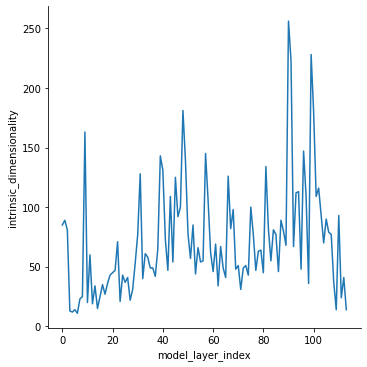

In [86]:
sns.relplot(data = intrinsic_dimensionality, x = 'model_layer_index', 
            y = 'intrinsic_dimensionality', kind = 'line');

In [87]:
intrinsic_dimensionality.query('model_layer_index == 103')

,model_layer,model_layer_index,intrinsic_dimensionality,model
103,Linear-45,103,93,vit_base_patch16_224


In [88]:
max_transform(intrinsic_dimensionality, group_vars = ['model'], measure_var = 'intrinsic_dimensionality')

,model_layer,model_layer_index,intrinsic_dimensionality,model
0,GELU-10,90,256,vit_base_patch16_224


In [89]:
min_transform(intrinsic_dimensionality, group_vars = ['model'], measure_var = 'intrinsic_dimensionality')

,model_layer,model_layer_index,intrinsic_dimensionality,model
0,Linear-2,6,11,vit_base_patch16_224


In [106]:
stimulus_features['Linear-45'][(response_data['dataset'] == 'vessel') & 
                               (response_data['image_type'] == 'lsc')].shape

(148, 6246)

In [141]:
x = np.round(stimulus_features['Linear-45'][(response_data['dataset'] == 'vessel') & 
                               (response_data['image_type'] == 'lsc')], 4)

In [279]:
x = stimulus_features['Linear-45'][(response_data['dataset'] == 'vessel') & 
                                   (response_data['image_type'] == 'lsc')]

In [114]:
pd.DataFrame(x).to_csv('ed_sample.csv', index = None)

In [316]:
pca = PCA().fit(x)

In [323]:
eigen_val = np.array(sorted(pca.explained_variance_))

In [329]:
#matrix = np.corrcoef(x)
matrix = np.cov(x.T)
eigen_val = np.array(sorted(np.linalg.eig(matrix)[0]))

In [330]:
K = len(eigen_val)
eigen_sum = sum(eigen_val)
norm_eigen_val = eigen_val/eigen_sum
eigen_var = np.var(eigen_val)*((K-1)/K)

In [331]:
n1 = np.prod(norm_eigen_val**(-norm_eigen_val))  
n2 = (eigen_sum**2)/sum(eigen_val**2) 
nInf = eigen_sum/max(eigen_val)    
nC = K - ((K**2)/(eigen_sum**2))*eigen_var

In [332]:
print(n1, n2, nInf, nC)

(119.94952258724187+1.8301127295864107e-14j) (89.1742779756719+0j) (23.452343328994935+0j) (6176.96843463397+0j)


In [328]:
print(n1, n2, nInf, nC)

119.94952258724172 89.17427797567208 23.45234332899491 147.34478582551003


In [225]:
np.round((n1.real,n2.real), 3)

array([46.356,  8.693])

In [100]:
skdim.id.lPCA(ver = 'participation_ratio').fit(stimulus_features['Linear-45']).dimension_

290

In [97]:
skdim.id.lPCA(ver = 'participation_ratio').fit(stimulus_features['GELU-10']).dimension_

432

In [98]:
skdim.id.lPCA(ver = 'participation_ratio').fit(stimulus_features['Linear-2']).dimension_

23

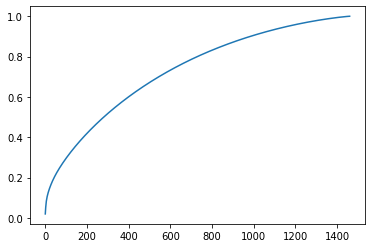

In [90]:
X = stimulus_features['GELU-10']
pca = PCA().fit(X)
pca.explained_variance_
plt.plot(np.cumsum(pca.explained_variance_ratio_));

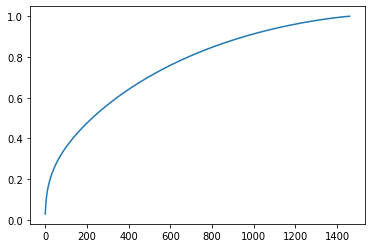

In [101]:
X = stimulus_features['Linear-45']
pca = PCA().fit(X)
pca.explained_variance_
plt.plot(np.cumsum(pca.explained_variance_ratio_));

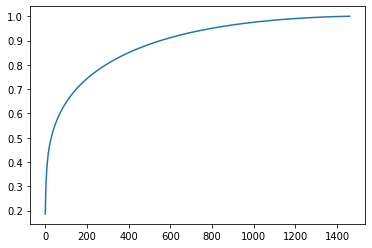

In [91]:
X = stimulus_features['Linear-2']
pca = PCA().fit(X)
pca.explained_variance_
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [220]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
# calculate the mean of each column
M = mean(A.T, axis=1)
# center columns by subtracting column means
C = A - M
# calculate covariance matrix of centered matrix
V = cov(C.T)
# eigendecomposition of covariance matrix
values, vectors = eig(V)
print(values)
# project data
P = vectors.T.dot(C.T)

[8. 0.]


In [221]:
# Principal Component Analysis
from numpy import array
from sklearn.decomposition import PCA
# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
# create the PCA instance
pca = PCA(2)
# fit on data
pca.fit(A)
# access values and vectors
#print(pca.components_)
print(pca.explained_variance_)
# transform data
B = pca.transform(A)

[8.00000000e+00 2.25080839e-33]


In [288]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
X = datasets.load_iris()['data']
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_scaled)

print('Explained Variance = ', pca.explained_variance_)
print('Principal Components = ', pca.components_)

Explained Variance =  [2.93808505 0.9201649  0.14774182 0.02085386]
Principal Components =  [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]
 [-0.71956635  0.24438178  0.14212637  0.63427274]
 [-0.26128628  0.12350962  0.80144925 -0.52359713]]


In [289]:
cov = np.cov(X_scaled.T)
eig_val, eig_vec = np.linalg.eig(cov)
print('Eigenvalues = ', eig_val)
print('Eigenvectors = ', eig_vec)

Eigenvalues =  [2.93808505 0.9201649  0.14774182 0.02085386]
Eigenvectors =  [[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]
